In [3]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from pprint import pprint
import seaborn as sns
sns.set_theme()
sns.set_palette(sns.color_palette('Set1'))

Direct binary classification

1. Seperate the dataframe into a features and label dataset
2. Break datasets down into training and test sets containing only unique mutations
3. Establish pipeline and parameter grid for LogisticRegression and grid search
4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY
5. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for AVERAGE PRECISION
6. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for AREA UNDER ROC CURVE
7. Precision-recall curve with best preprocessing and parameters for PRECISION
8. ROC curve with best preprocessing and parameters for AREA UNDER ROC CURVE
9. Use curves to determine if precision can be increased and FPR can be reduced
10. Produce confusion matrix with best parameters for precision or area under ROC curve (whichever gave best CV score)
11. Shift decision threshold to improve precision and FPR - reducing instances where resistant cases are predicted to be susceptible

1. Seperate the dataframe into a features and label dataset 

In [4]:
df = ML_data[['METHOD_MIC','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist','Site2_dist','SNAP2_score']]

# creates features numpy array
features = df[df.columns[2:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE'].to_numpy()

2. Break datasets down into training and test sets containing only unique mutations
- Also have a smaller test set to be used for cross-validaiton which comes from the training set

In [5]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    random_state=0)

In [6]:
# creates features and label dfs from unique mutations
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MUT_RESISTANCE'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MUT_RESISTANCE']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [7]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0, test_size = 0.2)

3. Establish pipeline and parameter grid for LogisticRegression and grid search

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

#create logistic regression pipeline with preprocessing 
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression(max_iter=10000))])
#create parameter grid with different preprocessing and classifier parameters
param_grid = {'preprocessing':[StandardScaler(), MinMaxScaler(), RobustScaler(), None],
              'classifier__C': [0.01, 0.1, 1, 10, 100], 'classifier__solver': \
              ['newton-cg', 'lbfgs', 'liblinear']}

4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY

In [8]:
#Search with shuffled cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=Kfold_shuffle)
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold_shuffle.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=10000,
                                    solver='newton-cg'))])
grid_kfold_shuffle: best cross-validation score:  0.7044520547945206
grid_kfold_shuffle: test set average accuracy:  0.7472527472527473 



5. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for AVERAGE PRECISION

In [9]:
#Grid search with with shuffled cross validation
#use decision function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test_cv, grid_kfold_shuffle.decision_function(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', None),
                ('classifier',
                 LogisticRegression(C=0.01, max_iter=10000,
                                    solver='newton-cg'))])
grid_kfold_shuffle: best cross-validation score:  0.7495108480302592
grid_kfold_shuffle test set average precision:  0.8231146595782061 



6. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for AREA UNDER ROC CURVE

In [10]:
#Grid search with with shuffled kfold cross validation
#use decision function to calculate AUC
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test_cv, grid_kfold_shuffle.decision_function(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier',
                 LogisticRegression(C=100, max_iter=10000,
                                    solver='liblinear'))])
grid_kfold_shuffle: best cross-validation score:  0.750472807841229
grid_kfold_shuffle test set AUC:  0.836231884057971 



7. Precision-recall curve with best preprocessing and parameters for PRECISION

Text(0.5, 1.0, 'Precision-recall curve for logistic regression (C=0.01, solver = "newton-cg")')

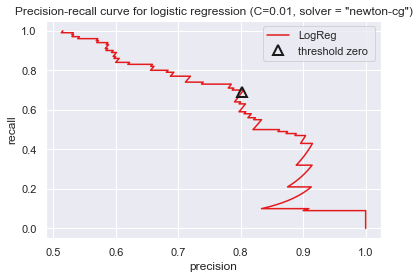

In [10]:
#use best preprocessing (None) and parameters (c=0.01, solver = 'newton-cg') for av. precision
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np
    
pipe = Pipeline([('preprocessing', None), 
                ('classifier', LogisticRegression(C=0.01, max_iter=10000, solver = 'newton-cg'))])

pipe.fit(X_train_cv, y_train_cv)
predict = (pipe.decision_function(X_test_nodup))

precision, recall, thresholds = precision_recall_curve(y_test_nodup, predict)

plt.figure(figsize=(6,4))
plt.plot(precision, recall, label='LogReg')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], '^', c='k', 
              markersize=10, label='threshold zero ', fillstyle='none', mew=2)
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')
plt.title('Precision-recall curve for logistic regression (C=0.01, solver = "newton-cg")')
#plt.savefig('figures/PR_curve_LR.png')

8. ROC
curve with best preprocessing and parameters for AREA UNDER ROC CURVE

Text(0.5, 1.0, 'ROC curve for logistic regression (MinMaxScaler(), C=100, solver = "liblinear")')

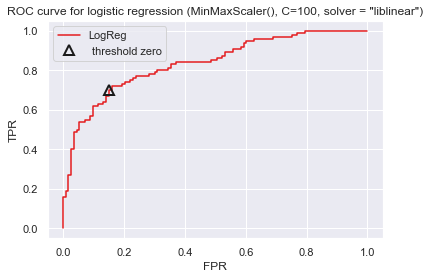

In [11]:
#use best preprocessing (MinMaxScaler()) and parameters (c=100, solver = 'liblinear') for best: ROC AUC
from sklearn.metrics import roc_curve

pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                ('classifier', LogisticRegression(C=100, max_iter=10000, solver = 'liblinear'))])
  
pipe.fit(X_train_cv, y_train_cv)

fpr, tpr, thresholds = roc_curve(y_test_nodup, pipe.decision_function(X_test_nodup))

plt.plot(fpr, tpr, label='LogReg')
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], '^', c='k',
         markersize=10, label=' threshold zero', fillstyle='none', mew=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.title('ROC curve for logistic regression (MinMaxScaler(), C=100, solver = "liblinear")')
#plt.savefig('figures/ROC_curve_LR.png')

9. Use curves to determine if precision can be increased and FPR can be reduced 

- Increase in precision leads to large drop in recall
- Making FPR smaller leads to a large drop in TPR

10. Produce confusion matrix with best parameters for precision or area under ROC curve (whichever gave best CV score)

In [12]:
#confusion matrix (MinMaxScaler()) and parameters (c=100, solver = 'liblinear') from ROC AUC

from sklearn.metrics import confusion_matrix

#build and fit pipieline
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                ('classifier', LogisticRegression(C=100, max_iter=10000, solver = 'liblinear'))])

pipe.fit(X_train_cv, y_train_cv)
predict = pipe.predict(X_test_nodup).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)

#calculate precision, sensitivity, specifcity, FPR, erros
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

# begins creates list for model comparison:
direct_VME = very_major_error
direct_ME = major_error

Precision:  0.8
Sensitivity:  0.68
Specificity:  0.8495575221238938
FPR : 0.1504424778761062
very major error : 15.04424778761062
major error:  32.0

 confusion matrix: 
 [[96 17]
 [32 68]]


{0: 128, 1: 85}


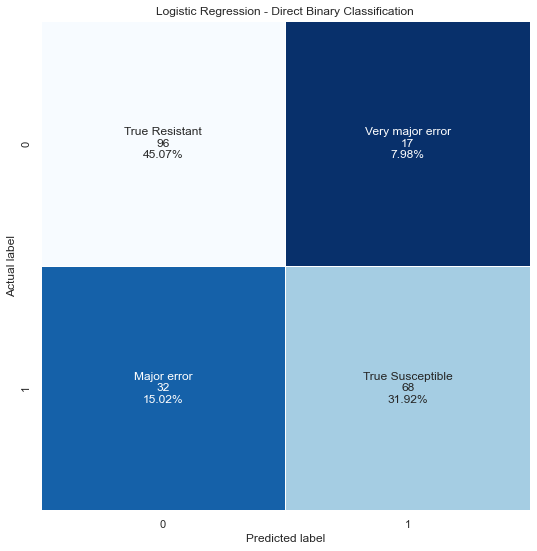

In [13]:
unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(y_test_nodup, predict)
plt.figure(figsize=(9,9))

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Logistic Regression - Direct Binary Classification');
#plt.savefig('figures/direct_unshifted_matrix_LR.png')

11. Shift decision threshold to improve precision and FPR - reducing instances where resistant cases are predicted to be susceptible

C:\Users\user\AppData\Local\Temp/ipykernel_12252/1934203934.py:24: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_12252/1934203934.py:24: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_12252/1934203934.py:24: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_12252/1934203934.py:24: RuntimeWarning: invalid value encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))
C:\Users\user\AppData\Local\Temp/ipykernel_12252/1934203934.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  grad_change = (m_error_cost / (-1*vm_error_cost))


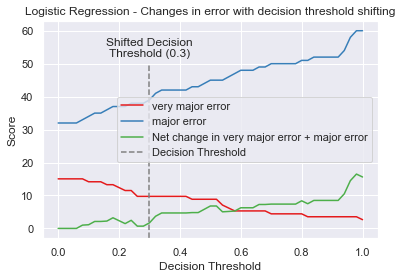

Optimum threshold to reduce very major error without     increasing major error by more than 1.5x :
 0.3


In [14]:
# graph showing how major and very major error changes with decision threshold

threshold  = np.linspace(0,1,num = 51)
very_major_error = []
major_error = []
net_error_change = []
threshold_shift = []

predict = (pipe.decision_function(X_test_nodup)>=0).astype(int)
confusion = confusion_matrix(y_test_nodup, predict)
og_very_major_error = ((confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100)
og_major_error = ((confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100)

for i in threshold:
    predict = (pipe.decision_function(X_test_nodup)>=i).astype(int)
    confusion = confusion_matrix(y_test_nodup, predict)
    very_major_error.append((confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100)
    major_error.append((confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100)

    #code to mathematically determine optimum threshold shifting
    vm_error_cost = ((confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100) - og_very_major_error
    m_error_cost = ((confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100) - og_major_error
    net_error_change.append(m_error_cost + vm_error_cost)
    grad_change = (m_error_cost / (-1*vm_error_cost))
    if grad_change <= 1.5:
        threshold_shift.append(i)
    
    
    
plt.plot(threshold, very_major_error, label = 'very major error')
plt.plot(threshold, major_error, label = 'major error')
plt.plot(threshold, net_error_change, label = 'Net change in very major error + major error')
plt.axvline(x=0.3, ymax=0.8, color ='grey', label = 'Decision Threshold', linestyle ='--')
plt.text(0.3,52,'Shifted Decision\nThreshold (0.3)', horizontalalignment = 'center')
plt.ylabel('Score')
plt.xlabel('Decision Threshold')
plt.legend()
plt.title('Logistic Regression - Changes in error with decision threshold shifting')
#plt.savefig('figures/decision_curve_LR.png')
plt.show()

if threshold_shift == []:
    optimum_thresh = 0
    print('Shifting does not improve results')
else:
    optimum_thresh = max(threshold_shift)
    print('Optimum threshold to reduce very major error without \
    increasing major error by more than 1.5x :\n'\
        ,max(threshold_shift))

In [15]:
# shift threshold accoriding to data above - optimum theshold to decrease FPR without
# increasing major error by more than 1.5 x
# = ~0.3

predict = (pipe.decision_function(X_test_nodup)>=optimum_thresh).astype(int)
confusion = confusion_matrix(y_test_nodup, predict)

Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100

print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)

print ('\n confusion_matrix: \n', confusion)

# adds to list for model quality comparison
shifted_direct_VME = very_major_error
shifted_direct_ME = major_error

Precision:  0.8472222222222222
Sensitivity:  0.61
Specificity:  0.9026548672566371
FPR : 0.09734513274336287
very major error : 9.734513274336283
major error:  39.0

 confusion_matrix: 
 [[102  11]
 [ 39  61]]


{0: 141, 1: 72}


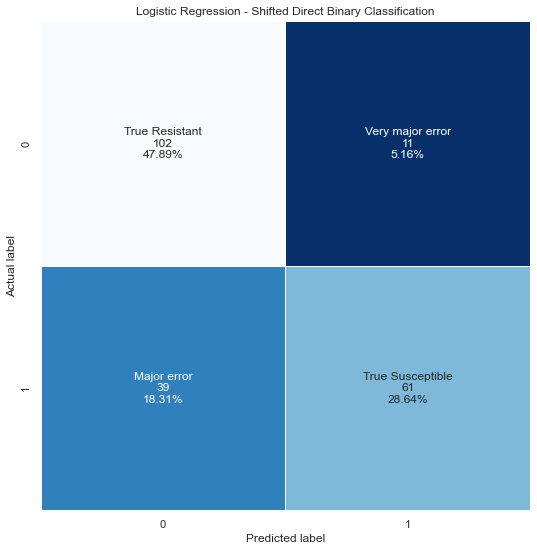

In [16]:
unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(y_test_nodup, predict)
plt.figure(figsize=(9,9))

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Logistic Regression - Shifted Direct Binary Classification');
#plt.savefig('figures/direct_shifted_matrix_LR.png')

Optimum model: preprocessing (MinMaxScaler()), parameters (c=100, solver = 'liblinear', threshold = 0.3)

Feature importance data for model comparison:

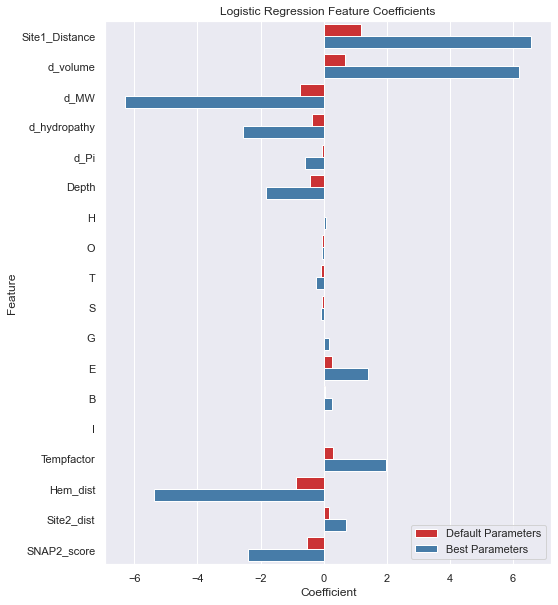

In [18]:
#Use standardscaler() for no_params 
#need to scale data to use coefficients for feature importance 
no_params = Pipeline([('preprocessing', StandardScaler()), 
                      ('classifier', LogisticRegression(max_iter=10000))])

best_params = Pipeline([('preprocessing', MinMaxScaler()),
                ('classifier',
                 LogisticRegression(C=100, max_iter=10000,
                                    solver='liblinear'))])

no_params.fit(X_train_cv, y_train_cv)
best_params.fit(X_train_cv, y_train_cv)

DF = pd.DataFrame({'Default Parameters':((no_params.named_steps['classifier'].coef_)[0]),
                   'Best Parameters':((best_params.named_steps['classifier'].coef_)[0]),
                   'n_features':np.arange(X_train_cv.shape[1])})
                          
df_melted = DF.melt("n_features",var_name="Params",value_name="importance")

sns.set_theme()
sns.set(rc={'figure.figsize':(8,10)})
sns.set_palette(sns.color_palette('Set1'))
x = sns.barplot(data=df_melted, x='importance', y='n_features', hue='Params', orient='h')
plt.yticks(DF['n_features'], df.columns[3:])
plt.title('Logistic Regression Feature Coefficients')
x.set(xlabel='Coefficient', ylabel='Feature')
plt.legend(loc='lower right')
plt.savefig('figures/direct_feature_coefficients_LR.png', bbox_inches='tight')

In [37]:
#produce relative importance df for best model for direct binary classification comparison
modal_df = abs(DF['Best Parameters'])
relative_importance = []
for i in modal_df:
    relative_importance.append(i / max(modal_df))
logreg_df = pd.DataFrame({'LR_relative_importance':relative_importance,
                   'n_features':np.arange(X_train_cv.shape[1])})
logreg_df.to_csv('LR_relative_importance.csv')

Indirect binary classification

1. Seperate the dataframe into a features and label dataset
2. Break datasets down into training and test sets containing only unique mutations
3. Establish pipeline and parameter grid for model and grid search
4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY
5. Produce confusion matrix with best parameters for ACCURACY
6. Convert predicted MIC to binary phenotype
7. Produce binary confusion matrix with best parameters for ACCURACY

1. Seperate the dataframe into a features and label dataset

In [38]:
MIC_ML_data = ML_data.dropna(subset = ['METHOD_MIC'])

In [39]:
# bunches up values >1.6 into one label as these vary due to difference in plates
MIC_strings = []

for i in MIC_ML_data['METHOD_MIC']:
    if i == '3.2':
        MIC_strings.append('>1.6')
    elif i == '6.4':
        MIC_strings.append('>1.6')
    elif i == '12.8':
        MIC_strings.append('>1.6')
    elif i == '>12.8':
        MIC_strings.append('>1.6')
    else:
        MIC_strings.append(i)
        
MIC_ML_data['MIC_values'] = MIC_strings

C:\Users\user\AppData\Local\Temp/ipykernel_19728/2143801672.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MIC_ML_data['MIC_values'] = MIC_strings


In [40]:
MIC_df = MIC_ML_data[['MIC_values','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist','Site2_dist','SNAP2_score']]

# creates features numpy array
MIC_features = MIC_df[MIC_df.columns[2:]].to_numpy()

#creates resistance label column
MIC_label = MIC_df['MIC_values'].to_numpy()

2. Break datasets down into training and test sets containing only unique mutations

In [41]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(MIC_features, MIC_label,
                                                    random_state=0)


In [42]:
# creates features and label dfs from unique mutations when the original train-test split 
# is inputted 
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MIC_VALUES'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #converts MIC_values to an integer so that the mean can be calculated for each mutation
    #with multiple samples
    MIC_integers = []

    for i in CV_train['MIC_VALUES']:
        if i == '<=0.025':
            MIC_integers.append(1)
        elif i == '0.05':
            MIC_integers.append(2)
        elif i == '0.1':
            MIC_integers.append(3)
        elif i == '0.2':
            MIC_integers.append(4)
        elif i == '0.4':
            MIC_integers.append(5)
        elif i == '0.8':
            MIC_integers.append(6)
        elif i == '1.6':
            MIC_integers.append(7)
        elif i == '>1.6':
            MIC_integers.append(8)
        
    CV_train['MIC_integers'] = MIC_integers

    #calculates the mean MIC value using the integer scale for each mutation
    MIC_calc_df = CV_train[['MUTATION','MIC_integers']].groupby('MUTATION').mean()
    
    #rounds the mean MIC value to the nearest integer for conversion back to the 
    #original MIC classes
    MIC_rounded = []
    for i in MIC_calc_df['MIC_integers']:
        rnd = round(i)
        MIC_rounded.append(rnd)
    MIC_calc_df['MIC_rounded'] = MIC_rounded
    
    #converts integers back to orignal MIC classes
    MIC_strings = []
    for i in MIC_calc_df['MIC_rounded']:
        if i == 1:
            MIC_strings.append('<=0.025')
        elif i == 2:
            MIC_strings.append('0.05')
        elif i == 3:
            MIC_strings.append('0.1')
        elif i == 4:
            MIC_strings.append('0.2')
        elif i == 5:
            MIC_strings.append('0.4')
        elif i == 6:
            MIC_strings.append('0.8')
        elif i == 7:
            MIC_strings.append('1.6')
        elif i == 8:
            MIC_strings.append('>1.6')   

    MIC_calc_df['MIC_final'] = MIC_strings

    # joins new MIC classes to CV_train df to replace the variation in MIC values associated
    # with mutations with multiple DST_measurements 
    MIC_calc_df.drop(['MIC_integers','MIC_rounded'], axis =1, inplace = True)
    CV_train.set_index('MUTATION', inplace = True)
    CV_train = CV_train.join(MIC_calc_df)
    CV_train.reset_index(inplace = True)
    CV_train.drop(['MIC_VALUES','MIC_integers'], axis = 1, inplace = True)
    CV_train.rename(columns = {'index':'MUTATION','MIC_final':'MIC_VALUES'}, inplace = True)
    
    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MIC_VALUES']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [43]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [44]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0, test_size = 0.2)

3. Establish pipeline and parameter grid for model and grid search

In [45]:
#build pipeline and paratmeter grid
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', \
            LogisticRegression(max_iter=100000000, multi_class = 'multinomial'))])
param_grid = {'preprocessing':[StandardScaler(), MinMaxScaler(), RobustScaler()],
              'classifier__C': [0.01, 0.1, 1, 10, 100],'classifier__solver': \
              ['newton-cg', 'lbfgs']}

4. Grid search with shuffled k fold cross validation to find best preprocessing and parameters for ACCURACY

In [46]:
#Grid search with shuffled kfold cross validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(pipe, param_grid, cv=Kfold_shuffle, n_jobs=-1)
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold_shuffle.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier',
                 LogisticRegression(C=10, max_iter=100000000,
                                    multi_class='multinomial',
                                    solver='newton-cg'))])
grid_kfold_shuffle: best cross-validation score:  0.2417338709677419
grid_kfold_shuffle: test set average accuracy:  0.2 



5. Produce confusion matrix with best parameters for ACCURACY

In [47]:
from sklearn.metrics import confusion_matrix

#build pipeline and fit
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('classifier', LogisticRegression(C=10,max_iter=100000000, \
                        multi_class='multinomial', solver='newton-cg'))])

pipe.fit(X_train_cv, y_train_cv)                 
                 
predict = pipe.predict(X_test_nodup)
#generate confusion matrix
target_names = ['<=0.025','0.05','0.1','0.2','0.4','0.8',  '1.6','>1.6']
confusion = confusion_matrix(y_test_nodup, predict, labels = target_names)

print ('\n multiclass confusion matrix: \n', confusion)


 multiclass confusion matrix: 
 [[4 3 0 0 1 0 0 0]
 [4 5 0 0 0 0 0 0]
 [3 2 0 2 2 0 0 3]
 [3 3 0 1 1 3 1 1]
 [0 2 0 0 2 0 0 4]
 [1 0 0 0 1 4 1 1]
 [0 0 0 0 0 1 0 3]
 [2 2 0 0 2 0 3 4]]


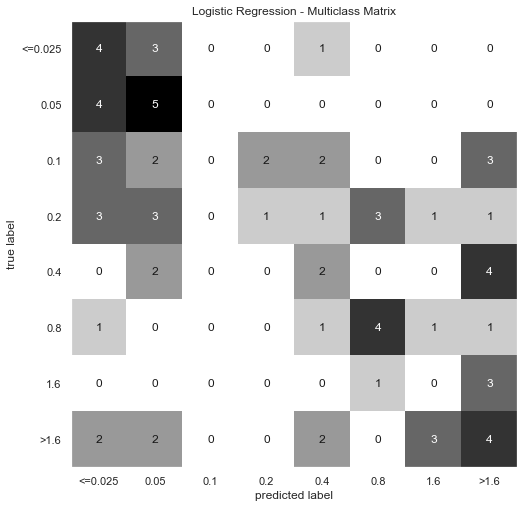

In [49]:
#generate heatmap of confusion matrix for visualisation

import mglearn

target_names = ['<=0.025','0.05','0.1','0.2','0.4','0.8', '1.6','>1.6']
scores_image = mglearn.tools.heatmap(confusion, xlabel='predicted label',
                                     ylabel='true label', xticklabels=target_names,
                                     yticklabels=target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('Logistic Regression - Multiclass Matrix')
plt.gca().invert_yaxis()
plt.savefig('figures/indirect_multiclass_matrix_LR.png')

In [51]:
#generate classification report
from sklearn.metrics import classification_report
print (classification_report(y_test_nodup, predict, zero_division=True))

              precision    recall  f1-score   support

        0.05       0.29      0.56      0.38         9
         0.1       1.00      0.00      0.00        12
         0.2       0.33      0.08      0.12        13
         0.4       0.22      0.25      0.24         8
         0.8       0.50      0.50      0.50         8
         1.6       0.00      0.00      0.00         4
     <=0.025       0.24      0.50      0.32         8
        >1.6       0.25      0.31      0.28        13

    accuracy                           0.27        75
   macro avg       0.35      0.27      0.23        75
weighted avg       0.40      0.27      0.23        75



6. Convert predicted MIC to binary phenotype

In [52]:
# will categorise multiclass data into 2 groups
def MIC_to_binary(data):
    RS_dict = {0:['0.2','0.4','0.8','1.6','>1.6'],
           1:['<=0.025','0.05','0.1']}
    binary_list = []
    for i in data:
        for k,v in RS_dict.items():
            for j in v:
                if i == j:
                    binary_list.append(k)

    binary_array = np.array(binary_list)
    return binary_array

7. Produce binary confusion matrix with best parameters for ACCURACY

Precision:  0.6176470588235294
Sensitivity:  0.7241379310344828
Specificity:  0.717391304347826
FPR : 0.28260869565217395
very major error : 28.26086956521739
major error:  27.586206896551722

 confusion matrix: 
 [[33 13]
 [ 8 21]]


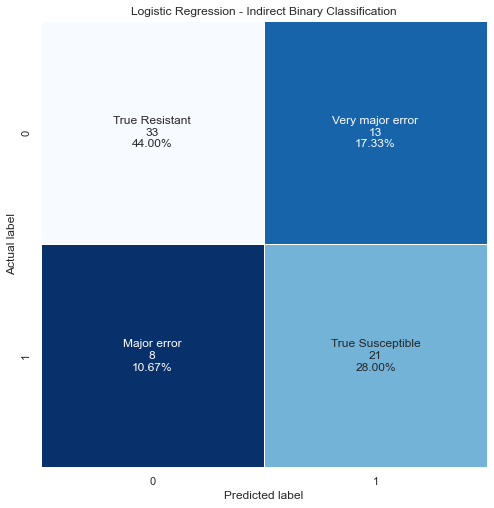

In [53]:
#convert MIC targets to binary targets and generate confusion matrix
predict = pipe.predict(X_test_nodup)
confusion = confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))
cm = metrics.confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))

#calculate precision, senstivity, specificty, FPR, and erros
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/len(MIC_to_binary(y_test_nodup)[MIC_to_binary(y_test_nodup)==0]))*100
major_error = (confusion[1][0]/len(MIC_to_binary(y_test_nodup)[MIC_to_binary(y_test_nodup)==1]))*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

group_names = ['True Resistant','Very major error','Major error','True Susceptible']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', linewidths=.5, square = True, cmap = 'Blues_r', cbar=False);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Logistic Regression - Indirect Binary Classification');
plt.savefig('figures/indirect_binary_matrix_LR.png')

#completes list of model quality values for model comparison
shifted_multiclass_VME = very_major_error
shifted_multiclass_ME = major_error

LR_quality = [direct_VME, direct_ME, shifted_direct_VME, shifted_direct_ME, \
              shifted_multiclass_VME,shifted_multiclass_ME]

logreg_quality_df = pd.DataFrame({'LR_quality':LR_quality})
logreg_quality_df.to_csv('LR_quality.csv')

In [54]:
print (classification_report(MIC_to_binary(y_test_nodup), MIC_to_binary(predict)))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76        46
           1       0.62      0.72      0.67        29

    accuracy                           0.72        75
   macro avg       0.71      0.72      0.71        75
weighted avg       0.73      0.72      0.72        75

